# In this notebook, we compile all programs used to generate power from tree trunk temperature differences. To run the code, hit "Run" above, and make sure to run all cells above the target cell.

## The structure of the notebook is :

  1. import all libraries and packages
  2. import all data files in csv format
  3. define hyperparameters
  4. define parameters
  5. generate boundary condition data
  6. main time stepping code
  7. compute generated current
  8. visualization

Import packages; numpy and scipy are for simulations; pandas for reading data; matplotlib and mpl_tookits.mplot3d for visualization. All experiments are run in Python3.

In [1]:
import numpy as np
import pandas
from scipy import sparse
from scipy.optimize import broyden1
from functools import partial
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Numpy version is", np.__version__)
import scipy

print("Scipy version is", scipy.__version__)

Python 3 version is 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Matplotlib version is 3.1.1
Numpy version is 1.17.2
Scipy version is 1.3.1


In [2]:
# regular save on laptop
# savefigpath = 'fig/'
# save on laptop for testing
# savefigpath = 'figPcoeffTest/'
# save absolute path desktop
savefigpath = '/Users/yajuna/Development/tree/notebook/fig_new_data/'

# if use air temperature as boudary condition
# airbdryFlag = '_airTempbdry'
# if use measured bark temperature as boudary condition
airbdryFlag = '_'

Define parameters used in time stepping- related to the properties of the trees and weather: thermal conductivity (W/(mK), $\rho$ the density (kg/m^3), specific heat (J/(kgK)); $\rho$ mutiplies specific heat gives the heat capacity; finally
albedo which impacts how much solar radiation is absorbed (taken to be 0.3 from Potter and Andresen 2002).

We choose a constant thermal conductivity, as numerical experiments show little difference.

In [3]:
#Define parameters
"""
n_x -- number of grid points, radially; interior points index from 1 to n_x - 1; bdry points are 0 and n_x.
n_t -- number of time steps
plot_at -- grid point at which a temperature curve is drawn
diff_at -- list of two grid points where the temp difference is computed
radius -- radius of tree, m
height -- height of tree, m
thermal_conductivity -- thermal conductivity of the tree, unit W/(mK)
rho -- density of tree trunk, unit kg/m^3
specific_heat -- specific_heat, unit J/(kgK)
albedo -- albedo constant; taken to be 0.3 from Potter Andresen pg.3
sigma -- Stefan–Boltzmann constant, 5.67 × 10 − 8 W ⋅ m − 2 ⋅ K − 4
"""
# test with n_x = 160 and n_t = 10
parameters = {"n_x": 160,
              "n_t": 1000,
              "sigma":5.76e-8,
              "plot_at": 3,
              "diff_at": [0, -1],
              "radius": 0.18,
              "thermal_conductivity": 1.8,# Notation Kt in code; k in paper # pg 3-17, wood handbook.
              "rho": 675,
              "specific_heat": 1700, # table 3-12, at 27 degrees, MC 12% (wood handbook)
              "albedo": 0.3, # 0.3 is concrete; 0.18, is grass#
              "boundary_type": "Dirichlet"
             } 

In [4]:
# testing cell

print(parameters)
print(parameters["n_x"])
print(type(parameters["radius"]))


n_t = parameters["n_t"]
time = np.linspace(0, 24, n_t, endpoint = False)
dt = time[1] - time[0]
    
n_x = parameters["n_x"]
radius = parameters["radius"]
    # Boundary conditions at trunk[0] and trunk[n_x]; Temperature[j] at trunk[j]; in matrix, only index from 1 to n_x-1 (labeled m)
trunk = np.linspace(0, radius, n_x+1)   
dr = radius / n_x
dr1 = trunk[1] - trunk[0]

print(dr - dr1)

r = 0.18
n_x = 160
trunk = np.linspace(0, r, n_x + 1)
itemindex = np.where(trunk==trunk[-2])
print(trunk[0],trunk[1],trunk[-1],trunk[n_x],trunk.shape,itemindex,trunk[itemindex],trunk[itemindex] + trunk[1])

{'n_x': 160, 'n_t': 1000, 'sigma': 5.76e-08, 'plot_at': 3, 'diff_at': [0, -1], 'radius': 0.18, 'thermal_conductivity': 1.8, 'rho': 675, 'specific_heat': 1700, 'albedo': 0.3, 'boundary_type': 'Dirichlet'}
160
<class 'float'>
0.0
0.0 0.001125 0.18 0.18 (161,) (array([159]),) [0.178875] [0.18]


### Import data from Weather_Station_OCT21_to_OCT28_2022.xlsx. 

Anemometer;wind_speed;Avg (m/s): Average wind speed in m/s measured by a anemometer

Wind Vane TMR;wind_direction;Avg (°): Average wind direction in ° measured by a Wind Vane

Hygro/Thermo;humidity;Avg (%): Average  humidity  in % measured by a Hygrometer

Hygro/Thermo;temperature;Avg (°C): Average temperature  in °C measured by a Hygrometer

Barometer;air_pressure;Avg (hPa): Average  air pressure  in  hPa   measured by a Barometer

DNI (Direct Normal Irradiance) Pyrheliometer;solar_DNI;Avg (W/m²):  Average Direct Normal Irradiance in W/m² measured by a Pyrheliometer.

OBS: The Direct Normal Irradiance is a measurement of the Solar Irradiance. The Global Irradiance is the sum of the DNI and the Diffuse Irradiance (https://www.sciencedirect.com/topics/engineering/direct-normal-irradiance [sciencedirect.com]). They say that DNI is the most important parameter in a solar plant installation. So, we need to see if the use of DNI (that is a fraction of the global solar irradiation is better for the model).

In [5]:
def make_weather_input(parameters):
    
    n_t = parameters["n_t"]
    
    colnames = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'temperature', 'air_pressure', 'solar_DNI']

    dataWeather = pandas.read_excel('Weather_Station_OCT21_to_OCT28_2022.xlsx', names = colnames)
   
    temp = dataWeather.temperature[2:145].tolist() # use data from Oct 21
    tempnp = np.asarray([float(t) for t in temp])
    
    tempnp = tempnp + 273.15

    windspeed = dataWeather.wind_speed[2:145].tolist()
    windspeednp = np.asarray([float(v) for v in windspeed])

    solar = dataWeather.solar_DNI[2:145].tolist()
    solarnp = np.asarray([float(v) for v in solar])

    air_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,tempnp.size),tempnp)
    windspeed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,windspeednp.size),windspeednp)
    solar = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,solarnp.size),solarnp)
    
    weather_input = {"air_temp": air_temp,
                  "windspeed": windspeed,
                  "solar": solar}
    return weather_input

### Plot the weather conditions

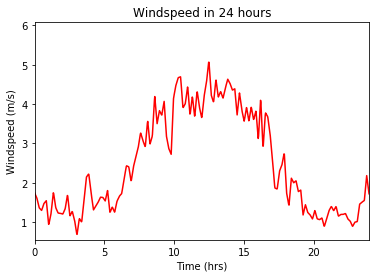

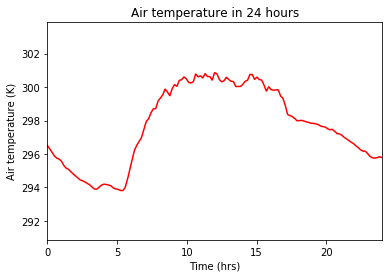

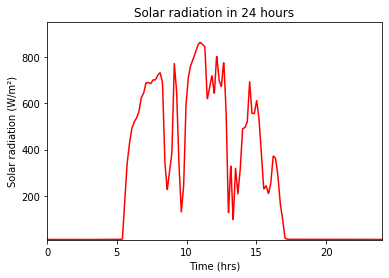

In [6]:
test_weather = make_weather_input(parameters)

Va = test_weather["windspeed"]
T_air = test_weather["air_temp"]
qrads = test_weather["solar"]

plt.plot(time, Va, 'r-')

message = f"Windspeed in 24 hours"
plt.title(message)
plt.axis([0, 24, Va.min() - Va.min() * 0.2, Va.max() + Va.max() * 0.2])
plt.xlabel('Time (hrs)')
plt.ylabel('Windspeed (m/s)')
plt.savefig(savefigpath + 'windspeed' + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show()    

plt.plot(time, T_air, 'r-')

message = f"Air temperature in 24 hours"
plt.title(message)
plt.axis([0, 24, T_air.min() - T_air.min() * 0.01, T_air.max() + T_air.max() * 0.01])
plt.xlabel('Time (hrs)')
plt.ylabel('Air temperature (K)')
plt.savefig(savefigpath + 'T_air' + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show()  

plt.plot(time, qrads, 'r-')

message = f"Solar radiation in 24 hours"
plt.title(message)
plt.axis([0, 24, qrads.min() - qrads.min() * 0.1, qrads.max() + qrads.max() * 0.1])
plt.xlabel('Time (hrs)')
plt.ylabel('Solar radiation (W/m²)')
plt.savefig(savefigpath + 'qrads' + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show()  

### Compute Reynolds numbers, Nusselt correlation, and heat convection (h) at each time step.

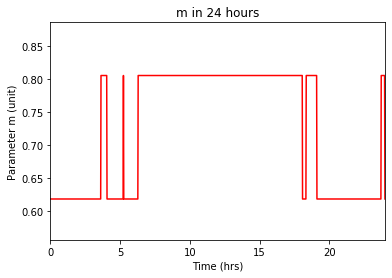

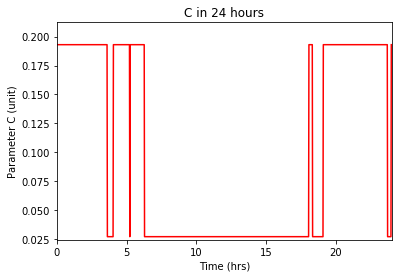

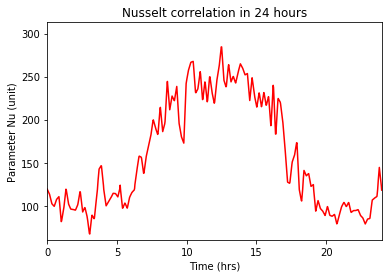

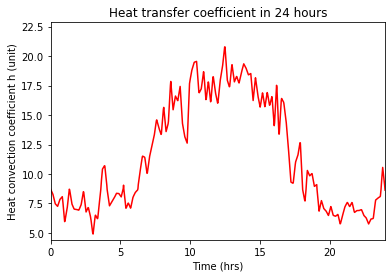

<class 'numpy.ndarray'> 1000 20.78516315719511 4.910978412892018 11.549079454838536


In [7]:

nu = 15.89e-6 # m^2/s kinematic viscosity of air
Pr = 0.707 
ka = 26.3e-3 # W/mK conductivity of air

coeff = 2 * radius/nu

Re = Va * coeff

C = []
m = []

for j in range(Va.size):
    temp = Re[j]
    if temp < 0.4:
        temp1 = [0, 0] 
    if 0.4<=temp<= 4:
        temp1 = [0.989, 0.330]
    if 4<temp<= 40:
        temp1 = [0.911, 0.385]
    if 40<temp<= 4e3:
        temp1 = [0.683, 0.466]
    if 4e3<temp<= 4e4:
        temp1 = [0.193, 0.618]
    if 4e4<temp<= 4e5:
        temp1 = [0.027, 0.805]
    
    C.append(temp1[0])
    m.append(temp1[1])
    

plt.plot(time, m, 'r-')

message = f"m in 24 hours"
plt.title(message)
plt.axis([0, 24, min(m) - min(m) * 0.1, max(m) + max(m) * 0.1])
plt.xlabel('Time (hrs)')
plt.ylabel('Parameter m (unit)')
plt.savefig(savefigpath + 'm' + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show()  

plt.plot(time, C, 'r-')

message = f"C in 24 hours"
plt.title(message)
plt.axis([0, 24, min(C) - min(C) * 0.1, max(C) + max(C) * 0.1])
plt.xlabel('Time (hrs)')
plt.ylabel('Parameter C (unit)')
plt.savefig(savefigpath + 'C' + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show()  


## Add computation for Nu for h at each time

Nu = C * Re ** m * Pr ** (1/3)


plt.plot(time, Nu, 'r-')
message = f"Nusselt correlation in 24 hours"
plt.title(message)
plt.axis([0, 24, Nu.min() - Nu.min() * 0.1, Nu.max() + Nu.max() * 0.1])
plt.xlabel('Time (hrs)')
plt.ylabel('Parameter Nu (unit)')
#plt.savefig(savefigpath + 'Nu' + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show() 

# print("size of Nu, max of Nu, min of Nu, and mean of Nu", Nu.size, Nu.max(), Nu.min(), Nu.mean())

h = Nu * ka / (2 * radius)


plt.plot(time, h, 'r-')
message = f"Heat transfer coefficient in 24 hours"
plt.title(message)
plt.axis([0, 24, h.min() - h.min() * 0.1, h.max() + h.max() * 0.1])
plt.xlabel('Time (hrs)')
plt.ylabel('Heat convection coefficient h (unit)')
plt.savefig(savefigpath + 'h' + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show() 

print(type(h), h.size, h.max(), h.min(), h.mean())

Import tree temperature data from Oct 21. 

The Tree Data Spreadsheet (Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx) has the following notation: 

DXX@YY where D = direction (N = North, S = South, E =East, W =West), XX = depth of the temperature sensor toward the tree core and YY= height of the temperature sensor. 

For example: S4.5cm@1m = sensor to the South 4.5 cm depth at 1 m height. 

Only the external sensor has a different notation, namely W_Ext_Temp@3.5m = to the West at 3.5 m height.

In [8]:
def make_temp_input(parameters):
    n_t = parameters["n_t"]
    colnames = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
    
    dataTemp = pandas.read_excel('Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx', names=colnames)

    coreTemp = dataTemp.w9_3[2:416].tolist() # Oct 21 -- core temp is West, at 9cm, at 3m high
    coreTempnp = np.asarray([float(t) for t in coreTemp])
    
    coreTempnp = coreTempnp + 273.15

    barkTemp = dataTemp.w_ext_35[2:416].tolist() # Oct 21 -- bark temp is West, at bark, at 3.5m high
    barkTempnp = np.asarray([float(v) for v in barkTemp])
    
    barkTempnp = barkTempnp + 273.15
    
    bark_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,barkTempnp.size),barkTempnp)
    core_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,coreTempnp.size),coreTempnp)
    diff_temp = bark_temp - core_temp #np.average(bark_temp - core_temp)
    
    temp_input = {"bark_temp": bark_temp,
                  "core_temp": core_temp,
                  "diff_temp": diff_temp}
    
    return temp_input    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


302.9877277277277 294.0888988988989
300.2687387387387 297.65


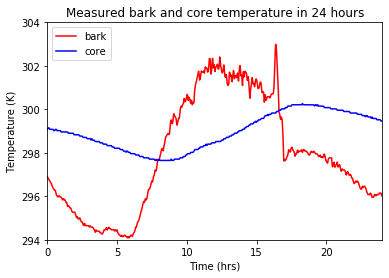

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


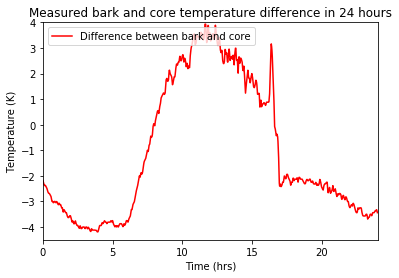

3.930000000000007 -4.189999999999998


In [9]:
temp_input = make_temp_input(parameters)


bark_temp = temp_input["bark_temp"]
core_temp = temp_input["core_temp"]
diff_temp = temp_input["diff_temp"]

print(bark_temp.max(), bark_temp.min())
print(core_temp.max(), core_temp.min())


plt.plot(time, bark_temp, 'r-', label='bark')
plt.plot(time, core_temp, 'b-', label='core')
plt.legend(loc="upper left")
message = f"Measured bark and core temperature in 24 hours"
plt.title(message)
plt.axis([0, 24, 294, 304])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')
plt.savefig(savefigpath + 'measured_temp' + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show() 

plt.plot(time, diff_temp, 'r-', label='Difference between bark and core')
plt.legend(loc="upper left")
message = f"Measured bark and core temperature difference in 24 hours"
plt.title(message)
plt.axis([0, 24, -4.5, 4])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')
plt.savefig(savefigpath + 'measured_diff_temp' + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show() 

print(diff_temp.max(), diff_temp.min())

In the one dimensional model, we see that temperature distribution depends on time $t$ and distance from the center $r$. 

\begin{equation}
\rho c\frac{\partial T}{\partial t}=\frac{1}{r}\frac{\partial}{\partial r}\bigg(kr\frac{\partial T}{\partial r}\bigg)+\text{ source terms}
=\frac{\partial k}{\partial r}\frac{\partial T}{\partial r}+\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2T}{\partial r^2}+\text{ source terms}.\label{heat1d}
\end{equation}

In the equation, $\rho$ represents density of the tree trunk; $c$ is the specific heat, and $k$ the thermal conductivity. 

Let $T^n_{i} \approx T(r_i,t_n)$ denote the numerical solution at the point $(r_i,t_n)$, $\Delta t$ the time step, and $\Delta r$ grid size. In this formulation, we have taken the thermal conductivity to be constant within the tree trunk. We denote the total source term to be $g_s(r,t)$, and use the source value $g_s(t)\frac{1}{\Delta r}$, because the sources are all surface energy fluxes, while the conduction terms apply to the model element volume. 

With second order central difference in space 
\begin{equation}\frac{\partial T}{\partial r}\approx\frac{T_{i+1}-T_{i-1}}{2\Delta r}\end{equation}
\begin{equation}\frac{\partial^2 T}{\partial r^2}\approx\frac{T_{i-1}-2T_{i}+T_{i+1}}{(\Delta r)^2}\end{equation}
and first order forward in time
\begin{equation}\frac{\partial T}{\partial t}\approx\frac{T^1-T^0}{\Delta t},\end{equation}
we obtain the Crank-Nicolson method by averaging the above spatial differences in time (no source):
\begin{align}
&(T^{n+1}_i - T^n_i)/\Delta t = 1/(4ar_i\Delta r)(T^n_{i+1}-T^n_{i-1} + T^{n+1}_{i+1}-T^{n+1}_{i-1} )\nonumber\\
&+1/(2a(\Delta r)^2)(T^n_{i-1} - 2T^n_i + T^n_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_i + T^{n+1}_{i+1}),\ (1)\label{1dCNscheme}
\end{align}
where $a = \frac{\rho c}{k}$. With the source value, we obtain

\begin{align}
&(T^{n+1}_i - T^n_i)/\Delta t = 1/(4ar_i\Delta r)(T^n_{i+1}-T^n_{i-1} + T^{n+1}_{i+1}-T^{n+1}_{i-1} )\nonumber\\
&+1/(2a(\Delta r)^2)(T^n_{i-1} - 2T^n_i + T^n_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_i + T^{n+1}_{i+1})+\frac{1}{2\rho c\Delta r}(g_s(r_i,t) + g_s(r_i,t+\Delta t)),\ (2)\label{1dCNschemeSource}
\end{align}

Separating terms from two time steps gives the following
\begin{equation}
\alpha_i T^1_{i-1} +(1+\beta)T^1_i-\gamma_iT^1_{i+1}=-\alpha_i T^0_{i-1} +(1-\beta)T^0_i+\gamma_iT^0_{i+1}+\frac{\Delta t}{2\rho c\Delta r}(g_s(r_i,t) + g_s(r_i,t+\Delta t)),\ (3)\end{equation}
where $\beta = \frac{\Delta t}{a(\Delta r)^2}$, $\alpha_i = \frac{\Delta t}{4ar_i\Delta r}-\frac{\Delta t}{2a(\Delta r)^2}$, and $\gamma_i = \frac{\Delta t}{4ar_i\Delta r}+\frac{\Delta t}{2a(\Delta r)^2}$

We implement two types of boundary conditions at the inner boundary:

1. no-flux condition (Neumann)
\begin{equation}
    \frac{\partial T}{\partial r}\bigg|_{r=0}=0,
\end{equation} 

for numerical simplicity (referenced in FireStem2D). Numerically, we use the second order central difference approximation $ \frac{\partial T}{\partial r}\bigg|_{r=0}\approx \frac{T_2-T_0}{2\Delta r}=0$, and the above equation gives a representation for the ghost cell value $T_0$ in terms of $T_2$. 

2. we enforce experimental data measured at the center of the tree trunk (Dirichlet)
\begin{equation}
    T(r=0, t)=g_0(t),\ \text{ where $g_0(t)$ is the measured data},
\end{equation} 

For the outer boundary, we implement three types of Dirichlet boundary condition:

1. with experimental data measured at location
\begin{equation}
    T(r=R, t)=g_1(t),\ \text{ measured data},
\end{equation} 

2. with experimental data measured at location, but approximated by the measured air temperature.
\begin{equation}
    T(r=0, t)=T_{air}(t),\ \text{ approximate air temperature},
\end{equation} 

3. with simulated data generated with the steady state solution.
\begin{equation}
    T(r=0, t)=T_{simulated}(t),\ \text{ simulated data},
\end{equation} 

The first row of the following matrix equation implements the inner boundary condtion, and the last row the outter boundary condition. The source term is also added to the last row. 

The following equations are similar to equation (9.9) in LeVeque's book on Finite Difference methods. Here the matrix is of size $(n_x -1)\times (n_x -1)$, with $T[0]$ the core and $T[n_x]$ the bark temperature that we do not solve- these are either read from experimental data, or simulated from weather data and pre obtained parameters. Here the index satisfies $n_x-1=m$. (for example, when $n_x = 160$, $m=159$,we solve for temperature values indexed 1 to 159)

If we apply Neumann condition at the center, and Dirichlet boundary condition at the tree bark:

\begin{equation*}
    \left( \begin{array}{cccc}
1+\beta & -\beta & & 0\\
\alpha_2 & 1+\beta & -\gamma_2 & \\
\ddots& \ddots & \ddots  & \\
& \alpha_{m-1} & 1+\beta & -\gamma_{m-1} \\
0 & & \alpha_m & 1+\beta \end{array} \right)\left(\begin{array}{c}
     T^1_1  \\
     T^1_2 \\
     \vdots\\
     T^1_{m-1}\\
     T^1_m
\end{array}\right)=\left( \begin{array}{cccc}
1-\beta & \beta & & 0\\
-\alpha_2 & 1-\beta & \gamma_2 & \\
\ddots& \ddots & \ddots  & \\
& -\alpha_{m-1} & 1-\beta & \gamma_{m-1} \\
0 & & -\alpha_m & 1-\beta \end{array} \right)\left(\begin{array}{c}
     T^0_1  \\
     T^0_2 \\
     \vdots\\
     T^0_{m-1}\\
     T^0_m
\end{array}\right)+\left(\begin{array}{c}
     0  \\
     0 \\
     \vdots\\
     0\\
     \gamma_m(g_1(t)+g_1(t+\Delta t))+\frac{\Delta t}{2\rho c\Delta r}(g_s(t)+g_s(t+\Delta t))
\end{array}\right).
\end{equation*}


Notice that the first row of the matrix represents the inner boundary condition: we first approximate $\partial T/\partial r \approx (T_2-T_0)/(2\Delta r)=0$, then the relation involving $T_1$ and $T_2$ is derived from equation (2) using $T_0 = T_2$. 

The last row of the matrix represents the outer boundary condition: $T(r = R, t) = g_1(t)$, and equation (2) implies
\begin{equation}
\alpha_m T^1_{m-1}+(1+\beta)T^1_m-\gamma_mg_1(t+\Delta t)=-\alpha_m T^0_{m-1}+(1-\beta)T^0_m+\gamma_mg_1(t)
\end{equation}
when we replace the ghost cell $T(r = R+\Delta r, t) \approx T^0_{m+1}$ by $g_1(t)$, and this becomes 
\begin{equation}
\alpha_m T^1_{m-1}+(1+\beta)T^1_m=-\alpha_m T^0_{m-1}+(1-\beta)T^0_m+\gamma_m(g_1(t) +g_1(t+\Delta t))
\end{equation}

Similarly, if we apply Dirichlet boundary condition at both the center and the tree bark,

\begin{equation*}
    \left( \begin{array}{cccc}
1+\beta & -\gamma_1 & & 0\\
\alpha_2 & 1+\beta & -\gamma_2 & \\
\ddots& \ddots & \ddots  & \\
& \alpha_{m-1} & 1+\beta & -\gamma_{m-1} \\
0 & & \alpha_m & 1+\beta \end{array} \right)\left(\begin{array}{c}
     T^1_1  \\
     T^1_2 \\
     \vdots\\
     T^1_{m-1}\\
     T^1_m
\end{array}\right)=\left( \begin{array}{cccc}
1-\beta & \gamma_1 & & 0\\
-\alpha_2 & 1-\beta & \gamma_2 & \\
\ddots& \ddots & \ddots  & \\
& -\alpha_{m-1} & 1-\beta & \gamma_{m-1} \\
0 & & -\alpha_m & 1-\beta \end{array} \right)\left(\begin{array}{c}
     T^0_1  \\
     T^0_2 \\
     \vdots\\
     T^0_{m-1}\\
     T^0_m
\end{array}\right)+\left(\begin{array}{c}
     -\alpha_1(g_0(t)+g_0(t+\Delta t))  \\
     0 \\
     \vdots\\
     0\\
     \gamma_m(g_1(t)+g_1(t+\Delta t))+\frac{\Delta t}{2\rho c\Delta r}(g_s(t)+g_s(t+\Delta t))
\end{array}\right).
\end{equation*}

Define the right hand side vectors for Neumann and Dirichlet conditions. Consider the system $AT^1 = BT^0 + v$, first row of $v$ would be 0 if Neumann at the core; and $-\alpha_1(T^1_0+T^0_0)$ if Dirichlet at core. Since both formulation uses Dirichlet outter boundary condition, and source terms are also at the bark, the last row in both cases is $\gamma_m(T^1_{m+1}+T^0_{m+1})+\frac{\Delta t}{2\rho c}(f_s(R,t)+f_s(R,t + \Delta t))$.

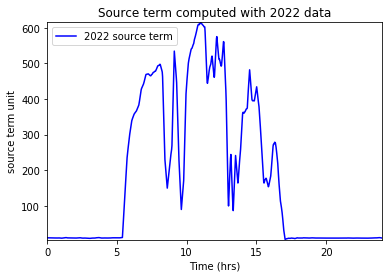

In [10]:
# Make source terms based on Potter and Andresen
sigma = 5.67e-8
albedo = parameters["albedo"]
sourceTerm = (1 - albedo) * qrads + sigma * (T_air**4 - bark_temp**4) + h * (bark_temp - T_air)

plt.plot(time, sourceTerm, 'b-', label='2022 source term')
# plt.plot(time, sourceTerm1, 'r-', label='2021 source term')
plt.legend(loc="upper left")
message = f"Source term computed with 2022 data"
plt.title(message)
plt.axis([0, 24, sourceTerm.min()-1, sourceTerm.max()+1])
plt.xlabel('Time (hrs)')
plt.ylabel('source term unit')
plt.show() 


In [11]:
# matrix needs to be made so that it is of size n_x - 1 by n_x - 1. m = n_x - 1

def time_stepping(parameters, bdry_type):
    
    sigma = 5.67e-8
    
    Kt = parameters["thermal_conductivity"]
    albedo = parameters["albedo"]
    n_x = parameters["n_x"]
    n_t = parameters["n_t"]
    radius = parameters["radius"]
    rho = parameters["rho"]
    specific_heat = parameters["specific_heat"]
    
    ### make utilities
    time = np.linspace(0, 24, n_t, endpoint = False)
    dt = time[1] - time[0]
    # Boundary conditions at trunk[0] and trunk[n_x]; Temperature[j] at trunk[j]; in matrix, only index from 1 to n_x-1 (labeled m)
    trunk = np.linspace(0, radius, n_x + 1)   
    dr = radius / n_x
    #dr = trunk[1] - trunk[0]
    
    heat_capacity = rho * specific_heat
    
    a = heat_capacity / Kt
    beta = dt / (a * dr ** 2)
    coeffSource = dt / (2 * heat_capacity * dr)
    
    # import measured temperature data
    temp_input = make_temp_input(parameters)
    core_temp = temp_input["core_temp"]
    bark_temp = temp_input["bark_temp"]
    
    # import weather condition
    weather_input = make_weather_input(parameters)
    air_temp = weather_input["air_temp"]
    windspeed = weather_input["windspeed"]
    solar = weather_input["solar"]
    
    convect = h * (bark_temp - air_temp)
#     print(h,convect)
    
    """
    compute source terms and then sum
    solar radiation = (1-albedo) * solar
    blackbody/long radiation = sigma * (Tair^4 - Tsfc^4)
    convection = h * (Tsfc - Tair)
    """
    # convect might change based on experimental data to reflect h * (Tsfc - Tair)

    sourceTerm = (1 - albedo) * solar + sigma * (air_temp**4 - bark_temp**4) + convect # 
    
    T0 = np.linspace(core_temp[0], bark_temp[0], n_x) # initialize temperature with measured initial condition

    
    alpha = np.linspace(1, n_x - 1, n_x - 1)# index from 0 to n_x - 2; cor. to points at 1 to n_x - 1
    for j in range(alpha.size):
        alpha[j] = dt / (4 * a * trunk[j + 2] * dr) - 0.5 * beta
    
    gamma = np.linspace(1, n_x - 1, n_x - 1)
    for j in range(gamma.size):
        gamma[j] = dt / (4 * a * trunk[j + 1] * dr) + 0.5 * beta
    
    # for the right hand side vector- alpha1 if Dirichlet at center; gammam is used for Dirichlet at the bark
    
    alpha1 = dt / (4 * a * trunk[1] * dr) - 0.5 * beta
    gammam = dt / (4 * a * trunk[-1] * dr) + 0.5 * beta
    
    # system of Ax_{n+1} = Bx_{n} + v    
    
    if bdry_type == "neumann":
        gamma[0] = beta  # define inner neumann bdry condition 1st row
        
   
    elif bdry_type == "dirichlet": 
        gamma[0] = dt / (4 * a * trunk[1] * dr) + 0.5 * beta

#     print(bdry_type, gamma[0])
    A = sparse.diags([alpha, np.ones(n_x) + beta, -gamma], [-1, 0, 1], shape=(n_x, n_x)).toarray()
    B = sparse.diags([-alpha, np.ones(n_x) - beta, gamma], [-1, 0, 1], shape=(n_x, n_x)).toarray()
    
    T1 = np.zeros((n_x,1))
    
    # soln to include initial temperature
    soln = [T0]
    
    ## time stepping: step1 compute B * T0; step2 rhs = B * T0 + v; step2 solve for T1 with T1 = A^-1 * rhs
    for time in range(n_t - 1):
        rhs = B.dot(T0)
        # with measured bark temperature
        rhs[-1] = rhs[-1] + gammam * (bark_temp[time] + bark_temp[time + 1]) + coeffSource * (sourceTerm[time] + sourceTerm[time + 1])
        # with measured air temperature
#         rhs[-1] = rhs[-1] + gammam * (air_temp[time] + air_temp[time + 1]) + coeffSource * (sourceTerm[time] + sourceTerm[time + 1])
        if bdry_type == "dirichlet": 
            rhs[0] = rhs[0] - alpha1 * (core_temp[time] + core_temp[time + 1])
        
        T1 = np.linalg.solve(A, rhs) 
        T0 = T1
        
        soln.append(T0) # start saving the solutions from time step 1 
    
    step_in_time = {"A": A,
                     "B": B,
                     "beta": beta,
                     "alpha": alpha,
                     "gamma": gamma,
                     "sourceTerm": sourceTerm,
                     "solution": soln}
    
    return step_in_time  
    

(1000, 160)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(1000, 160)


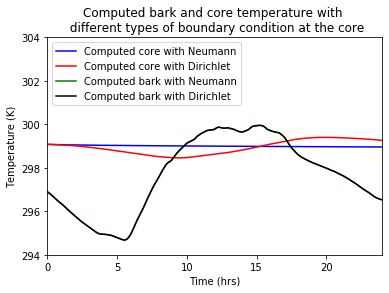

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


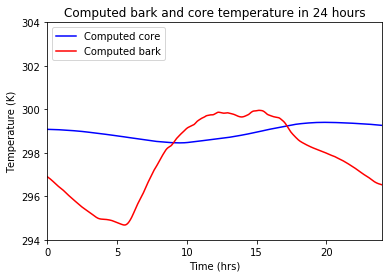

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


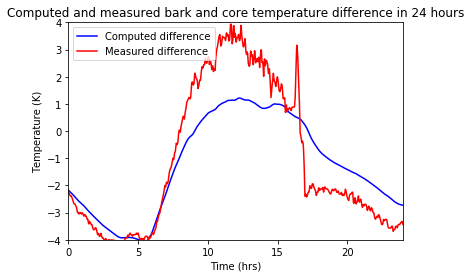

In [12]:
# test for different boundary conditions-- use Neumann condition to compute core temperature

step_neumann = time_stepping(parameters, bdry_type = "neumann")

solutionN = step_neumann["solution"]

solutionArrayN = np.asarray(solutionN)
print(solutionArrayN.shape)

step_dirichlet = time_stepping(parameters, bdry_type = "dirichlet")

solutionD = step_dirichlet["solution"]

solutionArrayD = np.asarray(solutionD)
print(solutionArrayD.shape)

plt.plot(time, solutionArrayN[:,0], 'b-', label='Computed core with Neumann')
plt.plot(time, solutionArrayD[:,0], 'r-', label='Computed core with Dirichlet')
plt.plot(time, solutionArrayN[:,-1], 'g-', label='Computed bark with Neumann')
plt.plot(time, solutionArrayD[:,-1], 'k-', label='Computed bark with Dirichlet')
# plt.plot(time, solutionArrayN[:,79], 'c-', label='Computed middle with Neumann')
# plt.plot(time, solutionArrayD[:,79], 'm-', label='Computed middle with Dirichlet')
plt.legend(loc="upper left")
message = f"Computed bark and core temperature with \n different types of boundary condition at the core"
plt.title(message)
plt.axis([0, 24, 294, 304])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')
plt.savefig(savefigpath + 'computed_temp_compare'+ airbdryFlag + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show() 

boundary_type = parameters["boundary_type"]

if boundary_type == "Dirichlet":
    solutionArray = solutionArrayD
if boundary_type == "Neumann":
    solutionArray = solutionArrayN   
    

plt.plot(time, solutionArray[:,0], 'b-', label='Computed core')
plt.plot(time, solutionArray[:,-1], 'r-', label='Computed bark')
# plt.plot(time, solutionArrayN[:,79], 'b-', label='Computed middle')
plt.legend(loc="upper left")
message = f"Computed bark and core temperature in 24 hours"
plt.title(message)
plt.axis([0, 24, 294, 304])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')

plt.savefig(savefigpath + 'computed_temp' + airbdryFlag + '.eps', format='eps', dpi=300,bbox_inches='tight')

plt.show() 

plt.plot(time, solutionArray[:,-1] - solutionArray[:,0], 'b-', label='Computed difference')
plt.plot(time, bark_temp - core_temp, 'r-', label='Measured difference')
plt.legend(loc="upper left")
message = f"Computed and measured bark and core temperature difference in 24 hours"
plt.title(message)
plt.axis([0, 24, -4, 4])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')
plt.savefig(savefigpath + 'computed_temp_diff'+ airbdryFlag + '.eps', format='eps', dpi=300,bbox_inches='tight')

plt.show() 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


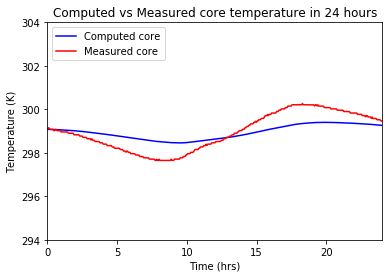

In [13]:
plt.plot(time, solutionArray[:,0], 'b-', label='Computed core')
plt.plot(time, core_temp, 'r-', label='Measured core')
plt.legend(loc="upper left")
message = f"Computed vs Measured core temperature in 24 hours"
plt.title(message)
plt.axis([0, 24, 294, 304])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')
plt.savefig(savefigpath + 'compare_core_temp'+ airbdryFlag + '.eps', format='eps', dpi=300,bbox_inches='tight')

plt.show() 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


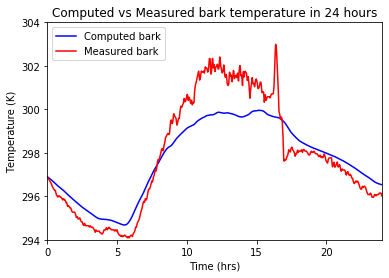

299.95461403470847 294.68025290638053 302.9877277277277 294.0888988988989


In [14]:
plt.plot(time, solutionArray[:,-1], 'b-', label='Computed bark')
plt.plot(time, bark_temp, 'r-', label='Measured bark')
plt.legend(loc="upper left")
message = f"Computed vs Measured bark temperature in 24 hours"
plt.title(message)
plt.axis([0, 24, 294, 304])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')
plt.savefig(savefigpath + 'compare_bark_temp' + airbdryFlag + '.eps', format='eps', dpi=300,bbox_inches='tight')

plt.show()

print(solutionArray[:,-1].max(), solutionArray[:,-1].min(), bark_temp.max(), bark_temp.min())

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


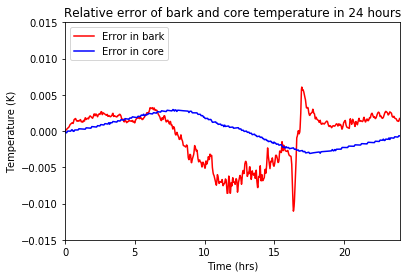

0.0060710283396092175 -0.01104662291529945 0.002965194225085956 -0.0030904232160099574


In [15]:
error_bark = (solutionArray[:,-1] - bark_temp)/bark_temp
error_core = (solutionArray[:,0] - core_temp)/core_temp

####### compute relative error of temperature difference
# error_diff = (solutionArray[:,-1] - solutionArray[:,0])/(bark_temp - core_temp)
# print(error_diff.max(), error_diff.min())


plt.plot(time, error_bark, 'r-', label='Error in bark')
plt.plot(time, error_core, 'b-', label='Error in core')
# plt.plot(time, error_diff, 'k-', label='Error in difference')

plt.legend(loc="upper left")
message = f"Relative error of bark and core temperature in 24 hours"
plt.title(message)
plt.axis([0, 24, -0.015, 0.015])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')
plt.savefig(savefigpath + 'compare_error_temp' + airbdryFlag + '.eps', format='eps', dpi=300,bbox_inches='tight')

plt.show() 

print(error_bark.max(), error_bark.min(), error_core.max(), error_core.min())

In [16]:
# # Plot measured air and bark temperature

# plt.plot(time, T_air, 'b-', label='Measured air ')
# plt.plot(time, bark_temp, 'r-', label='Measured bark')
# plt.legend(loc="lower right")
# message = f"Measured air and bark temperature in 24 hours"
# plt.title(message)
# plt.axis([0, 24, 294, 304])
# plt.xlabel('Time (hrs)')
# plt.ylabel('Temperature (K)')
# #plt.savefig(savefigpath + 'compare_measured_bark_air_temp' + '.eps', format='eps', dpi=300,bbox_inches='tight')
# plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


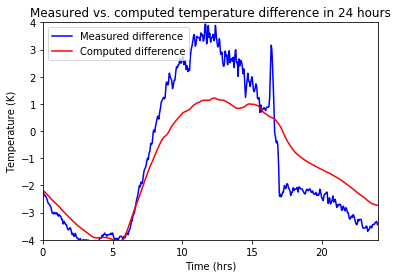

In [17]:
# Plot measured temperature difference and computed temperature difference

plt.plot(time, bark_temp - core_temp, 'b-', label='Measured difference')
plt.plot(time, solutionArray[:,-1] - solutionArray[:,0], 'r-', label='Computed difference')
plt.legend(loc="upper left")
message = f"Measured vs. computed temperature difference in 24 hours"
plt.title(message)
plt.axis([0, 24, -4, 4])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')
plt.savefig(savefigpath + 'compare_diff_temp' + airbdryFlag + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show()

### Compute the voltage generated by the temperature difference.

Max and min temperature difference are  4.055818270458985 0.0042992073953200816 at time 228 377
Max and min current are  194.6792769820313 0.20636195497536391 at time 228 377


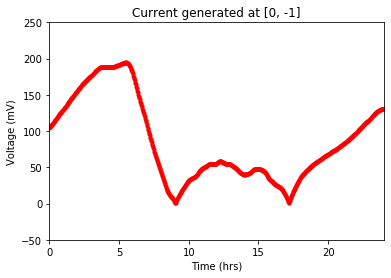

In [18]:
"""
convert temperature difference (core minus bark) to voltage

How to calculate the current (E) using the temperature difference. We will be 
using the Seebeck effect, so the calculation is super simple. E=-S*DeltaT. S 
is the Seebeck coefficient for wood, but the experimental project team already 
found this for us. So S=-0.259 mV/K if the outside temperature is colder than 
the tree (like night), and S=0.207 mV/K if the outside temperature is warmer 
than the tree [Cite Orlando Paper]. The DeltaT will be the difference between 
the core temperature and the bark temperature (in either C or K). The current 
you calculate E, will be in mV, and we should have a different value of E for 
each point in time we do the calculation for. 

Protasio Seebeck coeff: 120e-6K/V # 48mV/K (material: bismuth telluride, for a semi conductor), 
no switch of sign

TEG model: SP1848-27145 TEG Peltier Module Thermoelectric Power Generator 

run voltage

"""
s = 48 # mV/K

E = np.zeros((n_t,1))

diff_at = parameters["diff_at"]
TempDiff = np.abs(solutionArray[:, diff_at[0]] - solutionArray[:, diff_at[-1]])

weather = make_weather_input(parameters)
airTemp = weather["air_temp"]

E = s * TempDiff

print("Max and min temperature difference are ", TempDiff.max(), TempDiff.min(), "at time", np.argmax(TempDiff), np.argmin(TempDiff))
print("Max and min current are ", E.max(), E.min(), "at time", np.argmax(E), np.argmin(E))   

t = np.linspace(0, 24, E.size, endpoint=False) 

plt.plot(t, E, '.r-')
message = f"Current generated at {diff_at}"
plt.title(message)
plt.axis([0,24,-50,250])
plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (mV)')
plt.savefig(savefigpath + airbdryFlag + str(diff_at[0]) +str(diff_at[1]) + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show()    


In the following, we consider the boundary condition from heat conduction, convection, as well as radiation. The temperature is computed with the assumption that there is a energy steady state at the tree bark, where the incoming conduction energy balances with the outgoing convection and radiation energy.

### Use measured mid trunk temperature (in different direction and height) as bench mark to compare with computed mid trunk temperature 

In [22]:
def make_mid_temp(parameters):
    n_t = parameters["n_t"]
    colnames = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
    
    dataTemp = pandas.read_excel('Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx', names=colnames)

    s45_1Temp = dataTemp.s45_1[2:416].tolist() # Oct 21 -- 
    s45_1Tempnp = np.asarray([float(t) for t in s45_1Temp])
    
    s45_1Tempnp = s45_1Tempnp + 273.15

    w135_2Temp = dataTemp.w135_2[2:416].tolist() # Oct 21 -- 
    w135_2Tempnp = np.asarray([float(v) for v in w135_2Temp])
    
    w135_2Tempnp = w135_2Tempnp + 273.15
    
    s45_1_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,s45_1Tempnp.size),s45_1Tempnp)
    w135_2_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,w135_2Tempnp.size),w135_2Tempnp)
    
    mid_temp_input = {"s45_1_temp": s45_1_temp,
                  "w135_2_temp": w135_2_temp}
    
    return mid_temp_input  

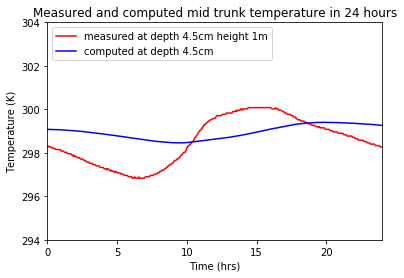

In [27]:
mid_temp = make_mid_temp(parameters)


s45_1_temp = mid_temp["s45_1_temp"]
w135_2_temp = mid_temp["w135_2_temp"]

plt.plot(time, s45_1_temp, 'r-', label='measured at depth 4.5cm height 1m')
plt.plot(time, solutionArray[:,0], 'b-', label='computed at depth 4.5cm')
plt.legend(loc="upper left")
message = f"Measured and computed mid trunk temperature in 24 hours"
plt.title(message)
plt.axis([0, 24, 294, 304])
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature (K)')
# plt.savefig(savefigpath + 'measured_mid_temp' + airbdryFlag +'.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show() 

In [26]:
print(solutionArray[:,80].max(), solutionArray[:,80].min())

297.98314465408805 297.97810312675483


In [25]:
print(solutionArray[:,0].max(), solutionArray[:,0].min())

299.40261011285986 298.4573089805851
